## Compare emissions and concentration driven SSP585 simulations

In [18]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

### Import CMIP6 output

In [2]:
import intake

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


Catalog on cloud has more output (glade not up to date?)

In [3]:
catalog = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")

Search for the experiments/variables, then futher refine by models (source_id) and ensemble members (member_id)

In [4]:
sr_nbp = catalog.search(experiment_id=['esm-ssp585','ssp585'], variable_id='nbp', 
                        source_id=['CanESM5', 'CESM2'],
                        member_id = ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1'])
#sr_nbp

In [5]:
sr_nbp.unique('grid_label')

{'grid_label': {'count': 1, 'values': ['gn']}}

### Get the fixed variables output, only available for historical simulations (gridcell area, landfrac)
Can subset the models and ensemble members

In [6]:
sr_fx_ctrl_vars = catalog.search(table_id = ['fx'], source_id = ['CanESM5','CESM2'], 
                                 member_id = ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1'], 
                                 experiment_id = 'historical', variable_id = ['areacella', 'sftlf'])

In [7]:
sr_fx_ctrl_vars.unique('grid_label')

{'grid_label': {'count': 1, 'values': ['gn']}}

### Convert the searchs to dictionaries

In [8]:
nbp_ds = sr_nbp.to_dataset_dict()

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 4 group(s)


In [9]:
nbp_ds.keys()

dict_keys(['C4MIP.CCCma.CanESM5.esm-ssp585.Lmon.gn', 'C4MIP.NCAR.CESM2.esm-ssp585.Lmon.gn', 'ScenarioMIP.CCCma.CanESM5.ssp585.Lmon.gn', 'ScenarioMIP.NCAR.CESM2.ssp585.Lmon.gn'])

In [10]:
fx_ds = sr_fx_ctrl_vars.to_dataset_dict()

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 2 group(s)


In [11]:
fx_ds.keys()

dict_keys(['CMIP.CCCma.CanESM5.historical.fx.gn', 'CMIP.NCAR.CESM2.historical.fx.gn'])

Grab NBP for both models / experiments

In [12]:
nbp_ssp_canesm = nbp_ds['ScenarioMIP.CCCma.CanESM5.ssp585.Lmon.gn'].nbp
nbp_esm_canesm = nbp_ds['C4MIP.CCCma.CanESM5.esm-ssp585.Lmon.gn'].nbp
nbp_ssp_cesm = nbp_ds['ScenarioMIP.NCAR.CESM2.ssp585.Lmon.gn'].nbp
nbp_esm_cesm = nbp_ds['C4MIP.NCAR.CESM2.esm-ssp585.Lmon.gn'].nbp

Grab landfrac and cell area for both models (different resolutions)

In [13]:
landfrac_cesm = fx_ds['CMIP.NCAR.CESM2.historical.fx.gn'].sftlf
area_cesm = fx_ds['CMIP.NCAR.CESM2.historical.fx.gn'].areacella
landfrac_canesm = fx_ds['CMIP.CCCma.CanESM5.historical.fx.gn'].sftlf
area_canesm = fx_ds['CMIP.CCCma.CanESM5.historical.fx.gn'].areacella

### Make weights for global sum
Convert landfrac from % to fraction between 0-1

In [14]:
landUp_cesm = area_cesm * landfrac_cesm / 100
landUp_canesm = area_canesm * landfrac_canesm / 100

Check lat diffs between fx vars and output

In [21]:
#latdiffs = landUp_cesm.lat.values - nbp_ssp_cesm.lat.values # MISMATCH
latdiffs = landUp_cesm.lat.values - nbp_esm_cesm.lat.values # MISMATCH
#latdiffs = landUp_canesm.lat.values - nbp_ssp_canesm.lat.values # OK
#latdiffs = landUp_canesm.lat.values - nbp_esm_canesm.lat.values # OK
#print(latdiffs)

CESM needs correction

In [17]:
landUp_cesm_modlat = landUp_cesm # create new landUp
landUp_cesm_modlat.lat.values = nbp_esm_cesm.lat.values # just assign landUp lats to match nbp lats
#print(landUp_cesm_modlat.lat.values - nbp_esm_cesm.lat.values) # sanity checks
#print(landUp_cesm_modlat.lat.values - nbp_ssp_cesm.lat.values)

### Weighted annual means

In [19]:
def weighted_annual_mean(array):
    mon_day  = xr.DataArray(np.array([31,28,31,30,31,30,31,31,30,31,30,31]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

Convert  to annual fluxes (kgC/m2/y), from kgC/m2/s 

In [20]:
spy = 365 * 24 * 3600

In [55]:
nbp_ssp_canesm_amean = weighted_annual_mean(nbp_ssp_canesm) * spy
nbp_ssp_canesm_amean.attrs['units'] = 'kgC m-2 y-1'
nbp_ssp_canesm_amean # 3 ensemble members for CanESM SSP
# NOTE - timeseries is longer but appears that not all members extend to 2300
nbp_ssp_canesm_amean.sel(time=slice("2015","2100")) # way to subsect 2015-2100 only to match other output

<xarray.DataArray 'year' (time: 86)>
array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025,
       2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036,
       2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047,
       2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058,
       2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069,
       2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080,
       2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091,
       2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100])
Coordinates:
  * time     (time) object 2015-12-16 12:00:00 ... 2100-12-16 12:00:00

In [50]:
nbp_esm_canesm_amean = weighted_annual_mean(nbp_esm_canesm) * spy
nbp_esm_canesm_amean.attrs['units'] = 'kgC m-2 y-1'
nbp_esm_canesm_amean # 3 ensemble members for CanESM ESM

<xarray.DataArray (member_id: 3, time: 86, lat: 64, lon: 128)>
dask.array<mul, shape=(3, 86, 64, 128), dtype=float64, chunksize=(1, 86, 64, 128), chunktype=numpy.ndarray>
Coordinates:
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * time       (time) object 2015-12-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U8 'r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1'
Attributes:
    units:    kgC m-2 y-1

In [24]:
nbp_ssp_cesm_amean = weighted_annual_mean(nbp_ssp_cesm) * spy
nbp_ssp_cesm_amean.attrs['units'] = 'kgC m-2 y-1'
nbp_ssp_cesm_amean # 2 ensemble members for CESM SSP

<xarray.DataArray (member_id: 2, time: 86, lat: 192, lon: 288)>
dask.array<mul, shape=(2, 86, 192, 288), dtype=float64, chunksize=(1, 50, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 2015-12-15 12:00:00 ... 2100-12-15 12:00:00
  * member_id  (member_id) <U8 'r1i1p1f1' 'r2i1p1f1'
Attributes:
    units:    kgC m-2 y-1

In [25]:
nbp_esm_cesm_amean = weighted_annual_mean(nbp_esm_cesm) * spy
nbp_esm_cesm_amean.attrs['units'] = 'kgC m-2 y-1'
nbp_esm_cesm_amean # 1 ensemble member for CESM ESM

<xarray.DataArray (member_id: 1, time: 86, lat: 192, lon: 288)>
dask.array<mul, shape=(1, 86, 192, 288), dtype=float64, chunksize=(1, 86, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 2015-12-15 12:00:00 ... 2100-12-15 12:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    units:    kgC m-2 y-1

### Calculate global sums
Instantaneous and cumulative

In [80]:
mean_wgt_cesm_ssp = nbp_ssp_cesm_amean * landUp_cesm_modlat
ann_glob_cesm_ssp = mean_wgt_cesm_ssp.sum(dim=('lat','lon')) * 1e-12 #convert to Pg/y
ann_glob_cesm_ssp.attrs['units'] = 'Pg C y^-1'
cann_glob_cesm_ssp = ann_glob_cesm_ssp.cumsum(dim='time')
cann_glob_cesm_ssp.attrs['units'] = 'Pg C'

In [81]:
mean_wgt_cesm_esm = nbp_esm_cesm_amean * landUp_cesm_modlat
ann_glob_cesm_esm = mean_wgt_cesm_esm.sum(dim=('lat','lon')) * 1e-12 #convert to Pg/y
ann_glob_cesm_esm.attrs['units'] = 'Pg C y^-1'
cann_glob_cesm_esm = ann_glob_cesm_esm.cumsum(dim='time')
cann_glob_cesm_esm.attrs['units'] = 'Pg C'

In [82]:
mean_wgt_canesm_ssp = nbp_ssp_canesm_amean * landUp_canesm
ann_glob_canesm_ssp = mean_wgt_canesm_ssp.sum(dim=('lat','lon')) * 1e-12 #convert to Pg/y
ann_glob_canesm_ssp.attrs['units'] = 'Pg C y^-1'
cann_glob_canesm_ssp = ann_glob_canesm_ssp.cumsum(dim='time')
cann_glob_canesm_ssp.attrs['units'] = 'Pg C'

In [83]:
mean_wgt_canesm_esm = nbp_esm_canesm_amean * landUp_canesm
ann_glob_canesm_esm = mean_wgt_canesm_esm.sum(dim=('lat','lon')) * 1e-12 #convert to Pg/y
ann_glob_canesm_esm.attrs['units'] = 'Pg C y^-1'
cann_glob_canesm_esm = ann_glob_canesm_esm.cumsum(dim='time')
cann_glob_canesm_esm.attrs['units'] = 'Pg C'

### Plot the timeseries

Way to calculate ensemble means

In [33]:
ann_glob_cesm_ssp.mean(dim="member_id")
ann_glob_cesm_esm.mean(dim="member_id")

<xarray.DataArray (time: 86)>
dask.array<mean_agg-aggregate, shape=(86,), dtype=float64, chunksize=(86,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-12-15 12:00:00 ... 2100-12-15 12:00:00

Instantaneous global sums

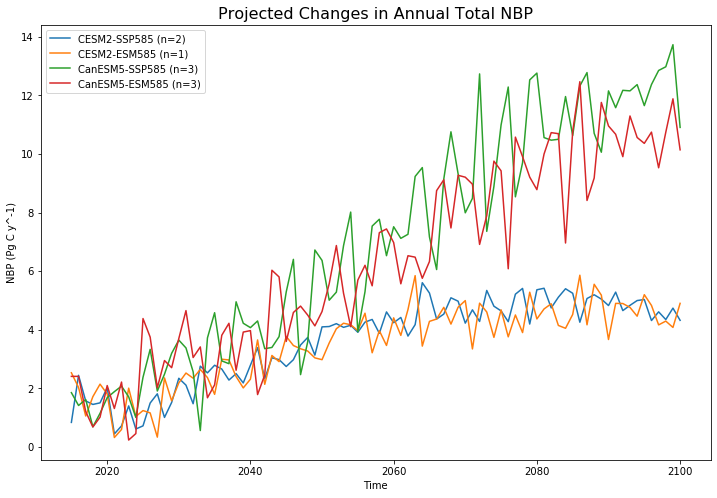

In [86]:
fig = plt.figure(figsize=(12, 8))

# Ask, out of a 1x1 grid, the first axes.
ax = fig.add_subplot(1, 1, 1)

# Plot times as x-variable and temperatures as y-variable
ax.plot(ann_glob_cesm_ssp.coords['time.year'], ann_glob_cesm_ssp.mean(dim="member_id"), label='CESM2-SSP585 (n=2)')
ax.plot(ann_glob_cesm_esm.coords['time.year'], ann_glob_cesm_esm.mean(dim="member_id"), label='CESM2-ESM585 (n=1)')
ax.plot(ann_glob_canesm_ssp.coords['time.year'].sel(time=slice("2015","2100")), 
        ann_glob_canesm_ssp.mean(dim="member_id").sel(time=slice("2015","2100")), label='CanESM5-SSP585 (n=3)')
ax.plot(ann_glob_canesm_esm.coords['time.year'].sel(time=slice("2015","2100")), 
        ann_glob_canesm_esm.mean(dim="member_id").sel(time=slice("2015","2100")), label='CanESM5-ESM585 (n=3)')
# Add some labels to the plot
ax.set_xlabel('Time')
ax.set_ylabel('NBP'+' (' + ann_glob_cesm_ssp.attrs['units'] +')')
ax.set_title('Projected Changes in Annual Total NBP', fontdict={'size':16})
ax.legend(loc='upper left');
#plt.savefig('cesm_canesm_ssp585_esm585_nbp.pdf')

Cummulative global sums

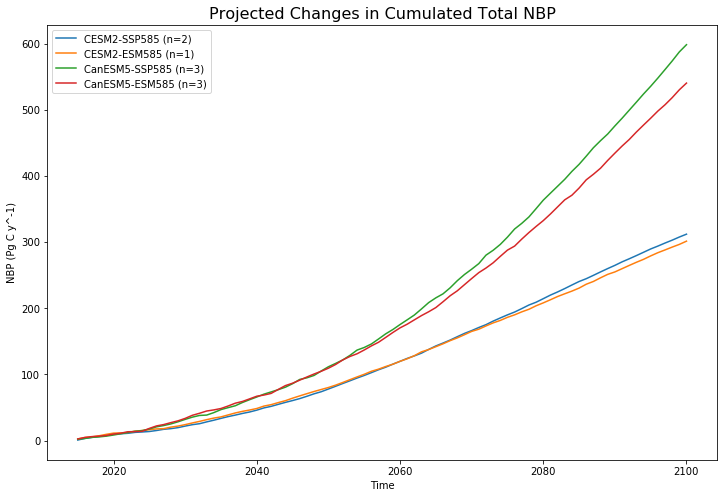

In [85]:
fig = plt.figure(figsize=(12, 8))

# Ask, out of a 1x1 grid, the first axes.
ax = fig.add_subplot(1, 1, 1)

# Plot times as x-variable and temperatures as y-variable
ax.plot(cann_glob_cesm_ssp.coords['time.year'], cann_glob_cesm_ssp.mean(dim="member_id"), label='CESM2-SSP585 (n=2)')
ax.plot(cann_glob_cesm_esm.coords['time.year'], cann_glob_cesm_esm.mean(dim="member_id"), label='CESM2-ESM585 (n=1)')
ax.plot(cann_glob_canesm_ssp.coords['time.year'].sel(time=slice("2015","2100")), 
        cann_glob_canesm_ssp.mean(dim="member_id").sel(time=slice("2015","2100")), label='CanESM5-SSP585 (n=3)')
ax.plot(cann_glob_canesm_esm.coords['time.year'].sel(time=slice("2015","2100")), 
        cann_glob_canesm_esm.mean(dim="member_id").sel(time=slice("2015","2100")), label='CanESM5-ESM585 (n=3)')
# Add some labels to the plot
ax.set_xlabel('Time')
ax.set_ylabel('NBP'+' (' + ann_glob_cesm_ssp.attrs['units'] +')')
ax.set_title('Projected Changes in Cumulated Total NBP', fontdict={'size':16})
ax.legend(loc='upper left');
#plt.savefig('cesm_canesm_ssp585_esm585_nbp_cumulative.pdf')